In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmdstanpy as stan
import os
import arviz as az
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10
import re
np.set_printoptions(legacy="1.25")

df = pd.read_csv('siaya_CFP.csv')
df = df.assign(mort72 = df['hr72'] / df['total'])
df.head(3)

#downcasting happening automatically - will be deprecated in future python
repl = df['generation'].replace(         #replace generation with integer for STAN
    to_replace=df['generation'].unique(),
    value=range(1, 5)
    )


/tmp/ipykernel_36353/2382357023.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  repl = df['generation'].replace(         #replace generation with integer for STAN


In [7]:
mort_ind = []
for row in range(len(df)):
    mort_ind.extend(np.repeat(1, df['hr72'][row]))
    mort_ind.extend(np.repeat(0 , df['total'][row] - df['hr72'][row]))

replicate = []
for row in range(len(df)):
    replicate.extend(np.repeat(repl[row], df['total'][row]))

dose = []
for row in range(len(df)):
    dose.extend(np.repeat(df['Dose'][row], df['total'][row]))

logisticdata =  {
    "D": 1,
    "N": len(mort_ind),
    "L": 4,
    "y": mort_ind,
    "ll": replicate,
    "x": dose,
}
stan.write_stan_json("data.json", logisticdata)

In [8]:
#building the dictionary of data for STAN
bottle_data = {
    "D": 1,
    "N": len(mort_ind),
    "L": 4, #figure out how to get this automatically from unique values of 'generation'
    "y": mort_ind,
    "ll": replicate,
    "x": dose
}
stan.write_stan_json("data.json", bottle_data)

In [9]:
my_stanfile = os.path.join('.', 'logistic.stan')
my_model = stan.CmdStanModel(stan_file=my_stanfile, cpp_options={'STAN_THREADS':'true'})
my_model.name
my_model.stan_file
my_model.exe_file
my_model.code()
fit=my_model.sample(data='data.json', show_console=True, iter_sampling=20000, 
                chains=4, inits=0)
print(fit.summary(percentiles=(.25, 97.5)))



13:54:06 - cmdstanpy - INFO - compiling stan file /home/daniel-hartman/Documents/OPEN_projects/Bayes_LC50/logistic.stan to exe file /home/daniel-hartman/Documents/OPEN_projects/Bayes_LC50/logistic
13:54:20 - cmdstanpy - INFO - compiled model executable: /home/daniel-hartman/Documents/OPEN_projects/Bayes_LC50/logistic
13:54:20 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 20000
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = data.json
init = 0
random
seed = 96587
output
file = /tmp/tmpm1j_znu5/logisticy2jjxq8f/logistic-20250513135420.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 4 (Default)


Gradient evaluation took 0.000302 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.02 second

13:54:56 - cmdstanpy - INFO - CmdStan done processing


Chain [3] Iteration: 20900 / 21000 [ 99%]  (Sampling)
Chain [3] Iteration: 21000 / 21000 [100%]  (Sampling)

Elapsed Time: 3.7 seconds (Warm-up)
32.174 seconds (Sampling)
35.874 seconds (Total)




13:54:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.0%)
	Chain 4 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


               Mean      MCSE    StdDev       MAD       0.25%       97.5%  \
lp__    -887.196000  0.021876  2.245840  2.014850 -896.922000 -884.085000   
mu         0.050070  0.000454  0.024800  0.008176   -0.083438    0.078432   
sigma      0.023261  0.000732  0.048053  0.008311    0.004814    0.081724   
b_0       -1.974240  0.000783  0.129117  0.129661   -2.349160   -1.724660   
beta[1]    0.035576  0.000014  0.002686  0.002690    0.028212    0.040903   
beta[2]    0.055841  0.000016  0.003056  0.003051    0.047536    0.061935   
beta[3]    0.055994  0.000015  0.002791  0.002794    0.048268    0.061527   
beta[4]    0.054712  0.000031  0.005876  0.005662    0.040882    0.067551   
lc50[1]   55.607000  0.008544  2.872690  2.846890   48.117900   61.480400   
lc50[2]   35.370600  0.006179  1.651460  1.640130   30.732100   38.609500   
lc50[3]   35.257400  0.006013  1.472850  1.467770   31.110300   38.130700   
lc50[4]   36.431500  0.019401  3.987730  3.947570   25.823200   44.492000   

<xarray.Dataset> Size: 152B
Dimensions:     (beta_dim_0: 4, lc50_dim_0: 4)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 32B 0 1 2 3
  * lc50_dim_0  (lc50_dim_0) int64 32B 0 1 2 3
Data variables:
    mu          float64 8B 1.0
    sigma       float64 8B 1.0
    b_0         float64 8B 1.0
    beta        (beta_dim_0) float64 32B 1.0 1.0 1.0 1.0
    lc50        (lc50_dim_0) float64 32B 1.0 1.0 1.0 1.0


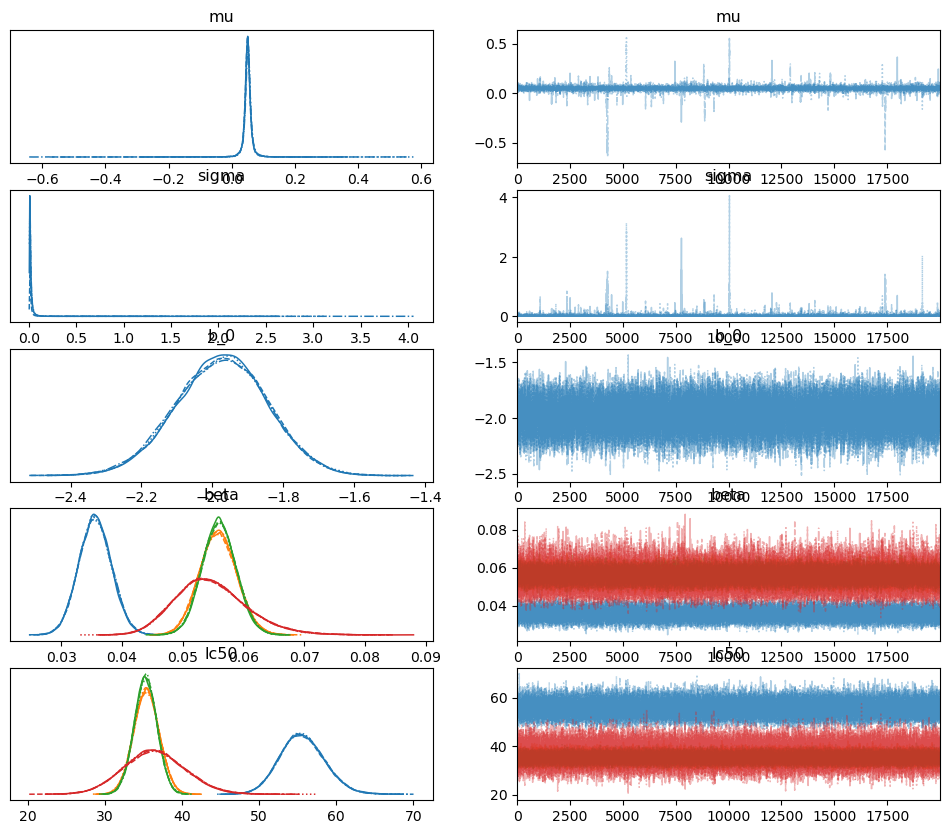

In [10]:
#arviz model diagnostics
az.plot_trace(data=fit, divergences=None)

#calculate R_hat to analyze convergence between chains. Values above 1 indicate lack of convergence.
print(az.rhat(data=fit))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

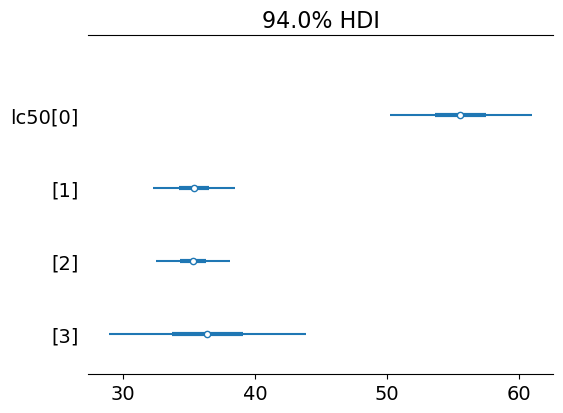

In [ ]:
#posterior predicitons

az.plot_forest(fit, var_names=['lc*'], filter_vars="regex",
               combined=True)
